In [1]:
import pandas as pd
df = pd.read_csv("processed_dataset.csv")

In [2]:
#df['% Silica Concentrate'].values

In [3]:
df.shape

(363781, 22)

In [4]:
for i, period in enumerate(df.columns):
    df[df.columns[i]] = df[df.columns[i]].shift(-3)

In [5]:
df = df.dropna()

In [6]:
df.shape

(363778, 22)

In [7]:
import os
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [8]:
def test_function(df,train_set_size,window_size,model, opt_comp):
    #print("Testing..")
    dump_df = pd.DataFrame(columns=['True Value', 'Predicted Values'])
    y_true = []
    y_pred = []
    mse_scores = []
    rmse_scores =[]
    mae_scores =[]
    #r2_scores = []
    
    df_test = df[train_set_size :int(train_set_size + train_set_size*0.2)]
    
    n_splits = len(df_test) - window_size
    for i in range(n_splits):
        
        scaler = StandardScaler()
        # Extract the current window of data
        window_data = df_test.iloc[i:i + window_size]

        X_test = window_data.iloc[:window_size].drop(columns=['% Silica Concentrate']).values
        y_test = window_data.iloc[:window_size]['% Silica Concentrate'].values

        X_test = scaler.fit_transform(X_test)
        
        y_test_pred = model.predict(X_test)

        # Taking true and predicted values for calculating R2
        y_true.append(y_test)
        y_pred.append(y_test_pred)
        
        # Calculate metric
        mse = mean_squared_error(y_test, y_test_pred)
        rmse = np.sqrt(((y_test - y_test_pred) ** 2).mean())
        mae = mean_absolute_error(y_test, y_test_pred)
        r2 = r2_score(y_test, y_test_pred)
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    dump_df['True Value'] = y_true
    dump_df['Predicted Values'] = y_pred

    dump_df.to_csv("./results/"+str(window_size)+"_"+str(opt_comp)+"_"+str(df_test.shape[0])+".csv",index=False)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    r2 = r2_score(y_true, y_pred)
    avg_mse = sum(mse_scores)/len(mse_scores)
    avg_rmse = sum(rmse_scores)/len(rmse_scores)
    avg_mae = sum(mae_scores)/len(mae_scores)
    
    print(f'Window size: {window_size}, Latent variables: {opt_comp}, Value of R2: {round(r2,2)},  \
        Average value of avg_mse, avg_rmse, avg_mae: {round(avg_mse,3)}, {round(avg_rmse,3)}, {round(avg_mae,3)}')
    return avg_mse,avg_rmse,avg_mae,r2

In [9]:
#df[0:190]["% Silica Concentrate"].to_list()

In [10]:
train_set_size = int(df.shape[0]*0.8)-1024

#train_set_size = 1000

df_train = df[0:train_set_size]

# Set the testing window size
testing_window_sizes = [40, 50]

latent_variables = [i for i in range(4,20)]
#latent_variables = [20]

# Run the model for all the records and only once
window_sizes = [df_train.shape[0]-1]
#window_sizes = [50]


metric_df = pd.DataFrame(columns=['Window Size', 'Latent Variables', 'MSE','MAE', 'RMSE', 'R2'])


for window_size in window_sizes:
    for n_components in latent_variables:
        

        scaler = StandardScaler()

        model = PLSRegression(n_components=n_components)

        
        n_splits = len(df_train) - window_size
        for i in tqdm(range(n_splits)):
            # Extract the current window of data
            window_data = df_train.iloc[i:i + window_size]

            # Split the window data into features (X) and target (y)
            X_train = window_data.iloc[:window_size].drop(columns=['% Silica Concentrate']).values
            y_train = window_data.iloc[:window_size]['% Silica Concentrate'].values

            X_train = scaler.fit_transform(X_train)
            
            
            try:
                model.fit(X_train, y_train)
            except Exception as e:
                #print(f"An exception occurred while fitting the model at split {i}.")
                continue

        for testing_window in testing_window_sizes:
            avg_mse, avg_rmse, avg_smape, r2 = test_function(df,train_set_size,testing_window,model, n_components)
            #avg_mse = np.mean(all_train_loss)
            metric_df = pd.concat([metric_df, pd.DataFrame({'Window Size': [testing_window], 'Latent Variables':  \
                [n_components], 'MSE': [avg_mse], 'MAE': [avg_smape], 'RMSE': [avg_rmse], 'R2': [r2]})], ignore_index=True)
            
        time.sleep(1)
    time.sleep(1)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Window size: 40, Latent variables: 4, Value of R2: -0.25,          Average value of avg_mse, avg_rmse, avg_mae: 1.991, 1.239, 1.155
Window size: 50, Latent variables: 4, Value of R2: -0.25,          Average value of avg_mse, avg_rmse, avg_mae: 1.99, 1.24, 1.154


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Window size: 40, Latent variables: 5, Value of R2: -0.29,          Average value of avg_mse, avg_rmse, avg_mae: 2.06, 1.274, 1.172
Window size: 50, Latent variables: 5, Value of R2: -0.29,          Average value of avg_mse, avg_rmse, avg_mae: 2.057, 1.273, 1.171


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


Window size: 40, Latent variables: 6, Value of R2: -0.31,          Average value of avg_mse, avg_rmse, avg_mae: 2.084, 1.286, 1.178
Window size: 50, Latent variables: 6, Value of R2: -0.3,          Average value of avg_mse, avg_rmse, avg_mae: 2.08, 1.285, 1.177


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Window size: 40, Latent variables: 7, Value of R2: -0.33,          Average value of avg_mse, avg_rmse, avg_mae: 2.115, 1.301, 1.186
Window size: 50, Latent variables: 7, Value of R2: -0.32,          Average value of avg_mse, avg_rmse, avg_mae: 2.111, 1.3, 1.185


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Window size: 40, Latent variables: 8, Value of R2: -0.35,          Average value of avg_mse, avg_rmse, avg_mae: 2.158, 1.322, 1.198
Window size: 50, Latent variables: 8, Value of R2: -0.35,          Average value of avg_mse, avg_rmse, avg_mae: 2.154, 1.321, 1.197


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Window size: 40, Latent variables: 9, Value of R2: -0.37,          Average value of avg_mse, avg_rmse, avg_mae: 2.182, 1.333, 1.204
Window size: 50, Latent variables: 9, Value of R2: -0.37,          Average value of avg_mse, avg_rmse, avg_mae: 2.179, 1.333, 1.203


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Window size: 40, Latent variables: 10, Value of R2: -0.37,          Average value of avg_mse, avg_rmse, avg_mae: 2.188, 1.336, 1.206
Window size: 50, Latent variables: 10, Value of R2: -0.37,          Average value of avg_mse, avg_rmse, avg_mae: 2.185, 1.335, 1.205


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Window size: 40, Latent variables: 11, Value of R2: -0.37,          Average value of avg_mse, avg_rmse, avg_mae: 2.188, 1.336, 1.206
Window size: 50, Latent variables: 11, Value of R2: -0.37,          Average value of avg_mse, avg_rmse, avg_mae: 2.185, 1.336, 1.205


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Window size: 40, Latent variables: 12, Value of R2: -0.37,          Average value of avg_mse, avg_rmse, avg_mae: 2.178, 1.331, 1.202
Window size: 50, Latent variables: 12, Value of R2: -0.36,          Average value of avg_mse, avg_rmse, avg_mae: 2.175, 1.33, 1.202


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Window size: 40, Latent variables: 13, Value of R2: -0.36,          Average value of avg_mse, avg_rmse, avg_mae: 2.166, 1.325, 1.199
Window size: 50, Latent variables: 13, Value of R2: -0.36,          Average value of avg_mse, avg_rmse, avg_mae: 2.162, 1.325, 1.198


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Window size: 40, Latent variables: 14, Value of R2: -0.36,          Average value of avg_mse, avg_rmse, avg_mae: 2.163, 1.324, 1.199
Window size: 50, Latent variables: 14, Value of R2: -0.35,          Average value of avg_mse, avg_rmse, avg_mae: 2.16, 1.324, 1.198


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Window size: 40, Latent variables: 15, Value of R2: -0.35,          Average value of avg_mse, avg_rmse, avg_mae: 2.161, 1.323, 1.198
Window size: 50, Latent variables: 15, Value of R2: -0.35,          Average value of avg_mse, avg_rmse, avg_mae: 2.158, 1.323, 1.197


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Window size: 40, Latent variables: 16, Value of R2: -0.35,          Average value of avg_mse, avg_rmse, avg_mae: 2.158, 1.321, 1.197
Window size: 50, Latent variables: 16, Value of R2: -0.35,          Average value of avg_mse, avg_rmse, avg_mae: 2.154, 1.321, 1.196


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Window size: 40, Latent variables: 17, Value of R2: -0.35,          Average value of avg_mse, avg_rmse, avg_mae: 2.155, 1.32, 1.197
Window size: 50, Latent variables: 17, Value of R2: -0.35,          Average value of avg_mse, avg_rmse, avg_mae: 2.152, 1.32, 1.196


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


Window size: 40, Latent variables: 18, Value of R2: -0.35,          Average value of avg_mse, avg_rmse, avg_mae: 2.155, 1.32, 1.197
Window size: 50, Latent variables: 18, Value of R2: -0.35,          Average value of avg_mse, avg_rmse, avg_mae: 2.152, 1.32, 1.196


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Window size: 40, Latent variables: 19, Value of R2: -0.35,          Average value of avg_mse, avg_rmse, avg_mae: 2.155, 1.32, 1.197
Window size: 50, Latent variables: 19, Value of R2: -0.35,          Average value of avg_mse, avg_rmse, avg_mae: 2.152, 1.32, 1.196


In [11]:
#metric_df

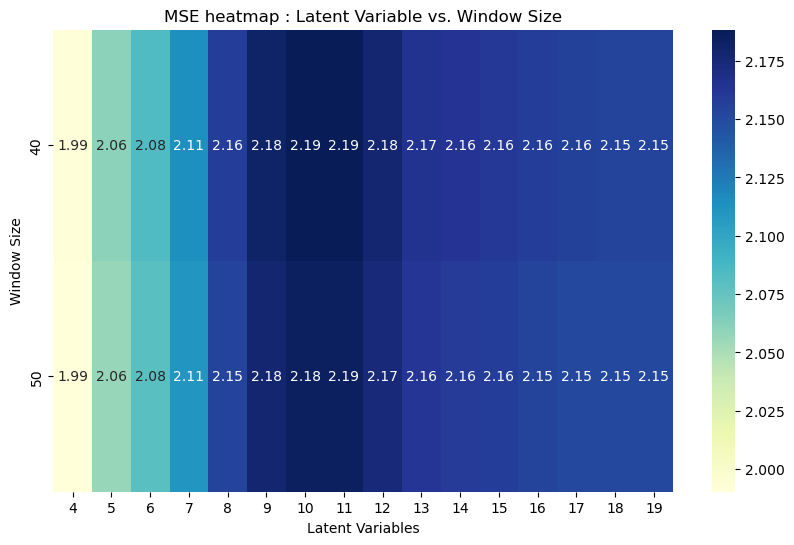

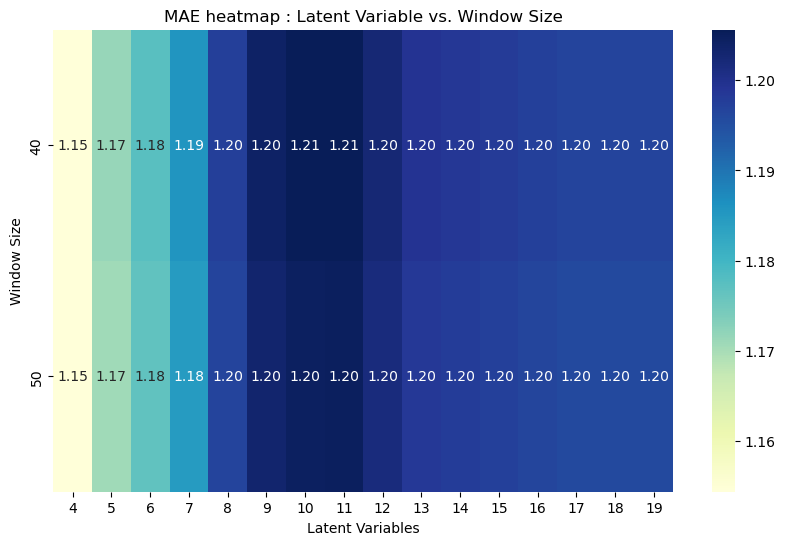

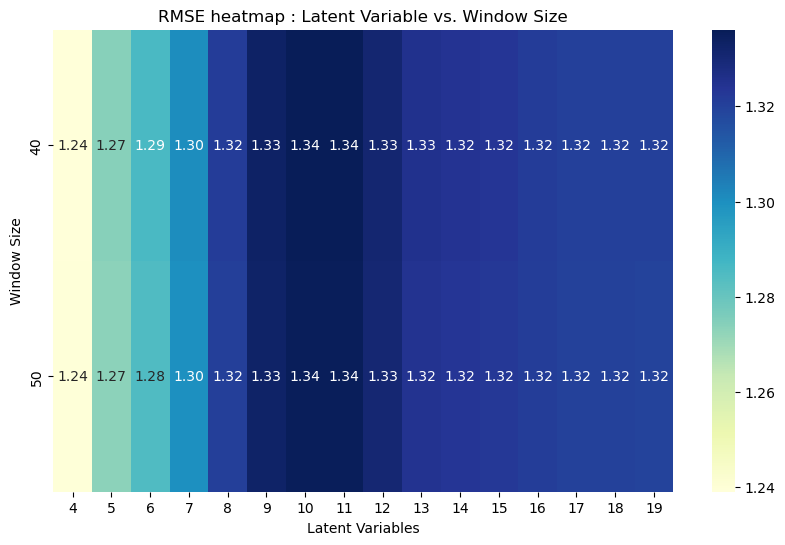

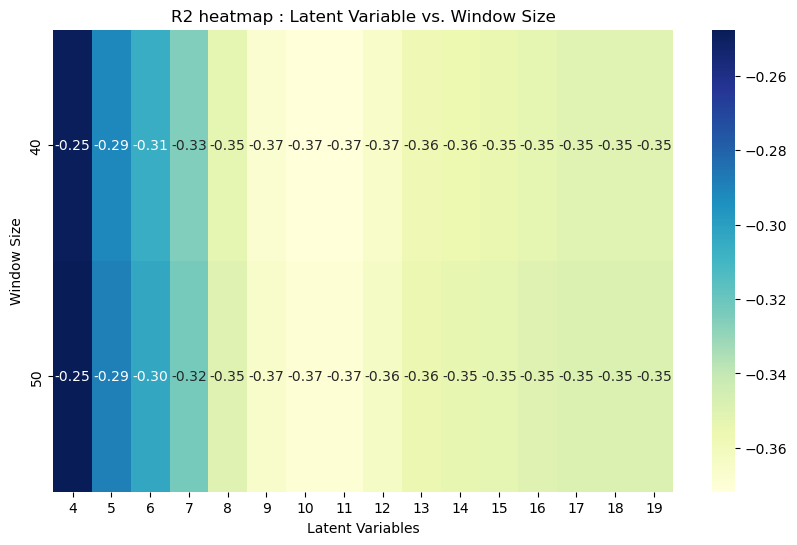

In [12]:
# Create a heatmap
for col in ['MSE','MAE', 'RMSE', 'R2']:
    heatmap_data = metric_df.pivot_table(index='Window Size', columns='Latent Variables', values=col, aggfunc='mean')
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(col+' heatmap : Latent Variable vs. Window Size')
    plt.xlabel('Latent Variables')
    plt.ylabel('Window Size')
    plt.show()